In [63]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, f1_score

import os
import zipfile
import random
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Используемое устройство: {device}')


Используемое устройство: cuda


Разархивирование

In [64]:
zip_path = "/content/writerextnd.zip"
extract_path = "/content/writerextnd"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Архив успешно разархивирован!")

# Файлы внутри архива
for root, dirs, files in os.walk(extract_path):
    for filename in files:
        print(os.path.join(root, filename))


✅ Архив успешно разархивирован!
/content/writerextnd/author17.txt
/content/writerextnd/author11.txt
/content/writerextnd/author20.txt
/content/writerextnd/Fry.txt
/content/writerextnd/Strugatskie.txt
/content/writerextnd/author19.txt
/content/writerextnd/author4.txt
/content/writerextnd/Bulgakov.txt
/content/writerextnd/Genri.txt
/content/writerextnd/author5.txt
/content/writerextnd/author7.txt
/content/writerextnd/author21.txt
/content/writerextnd/author18.txt
/content/writerextnd/author9.txt
/content/writerextnd/author8.txt
/content/writerextnd/Simak.txt
/content/writerextnd/author14.txt
/content/writerextnd/author15.txt
/content/writerextnd/Bradbury.txt
/content/writerextnd/author3.txt
/content/writerextnd/author12.txt
/content/writerextnd/author16.txt
/content/writerextnd/author1.txt
/content/writerextnd/author13.txt
/content/writerextnd/example.csv
/content/writerextnd/author6.txt
/content/writerextnd/author2.txt
/content/writerextnd/author10.txt


Создаю DataFrame

In [65]:
folder_path = '/content/writerextnd/'

# Список файлов в папке
files = os.listdir(folder_path)

# Список для хранения данных
data = []

for filename in files:
    if filename.endswith('.txt'):
        author_name = filename.replace('.txt', '')
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            # Разделение по абзацам или предложениям
            paragraphs = text.split('\n\n')
            for paragraph in paragraphs:
                cleaned_paragraph = paragraph.strip()
                if len(cleaned_paragraph) > 20:
                    data.append([cleaned_paragraph, author_name])

# DataFrame
df = pd.DataFrame(data, columns=['text', 'author'])

print(f'Размер датафрейма: {df.shape}')
df.head()


Размер датафрейма: (58023, 2)


,text,author
0,"﻿Темные вассалы Гленке Тавала\n– Знаешь, сэр Н...",author17
1,"﻿Лягушка тяжко шевельнула головой, и в ее...",author11
2,"﻿Профессор усмехнулся, прищурился на калоши ...",author20
3,– С тех пор как меня угораздило побывать в это...,Fry
4,– Я даже не стану тратить драгоценное время на...,Fry


Анализ классов

Количество текстов у каждого автора:
author
Fry            18307
Simak           9412
Bradbury        9221
Strugatskie     9084
Bulgakov        7966
Genri           3683
author18         149
author9          104
author19          74
author4            3
author16           2
author12           2
author2            2
author7            1
author20           1
author17           1
author5            1
author11           1
author8            1
author15           1
author14           1
author21           1
author3            1
author1            1
author13           1
author6            1
author10           1
Name: count, dtype: int64


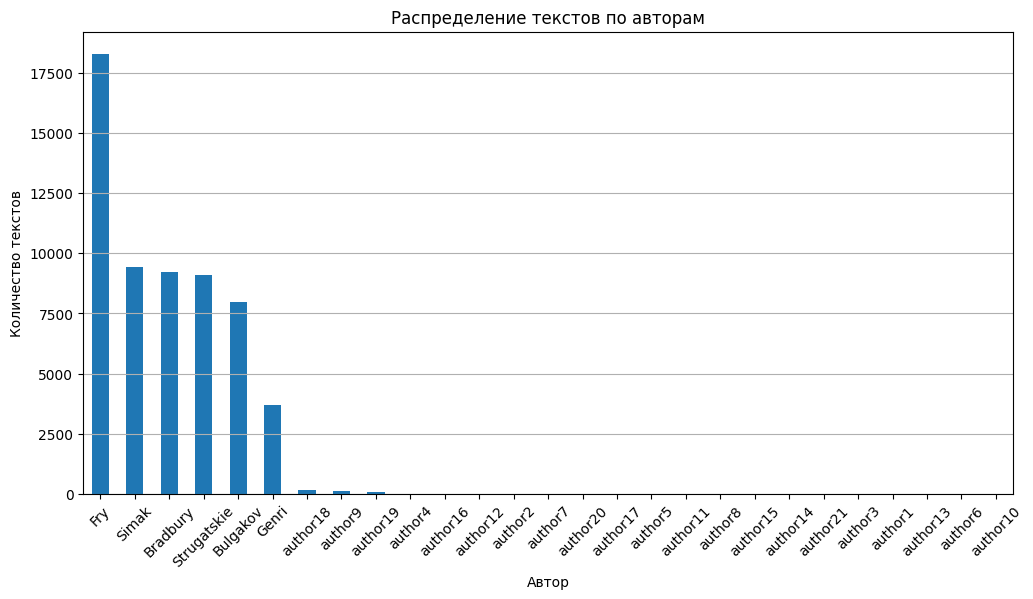

In [66]:
# Количество текстов для каждого автора
author_counts = df['author'].value_counts()

print("Количество текстов у каждого автора:")
print(author_counts)

# График распределения
plt.figure(figsize=(12, 6))
author_counts.plot(kind='bar')
plt.title('Распределение текстов по авторам')
plt.xlabel('Автор')
plt.ylabel('Количество текстов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


Фильтрация датасета. Оставляю только круспные классы, чтобы мелкие классы не мешали обучению модели

Размер отфильтрованного датафрейма: (57673, 2)


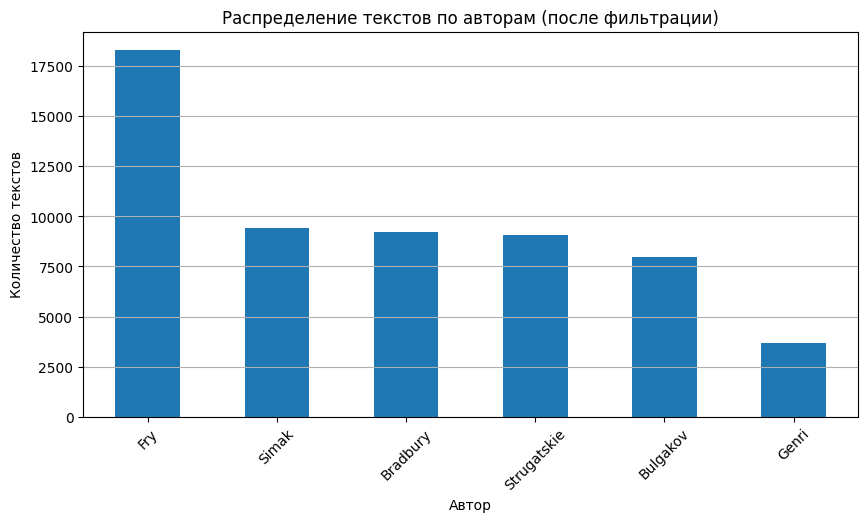

In [67]:
# Выбор авторов (более 1000 текстов)
popular_authors = author_counts[author_counts > 1000].index
df_filtered = df[df['author'].isin(popular_authors)]

print("Размер отфильтрованного датафрейма:", df_filtered.shape)

# Распределение после фильтрации
df_filtered['author'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Распределение текстов по авторам (после фильтрации)')
plt.xlabel('Автор')
plt.ylabel('Количество текстов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


Предобработка текста

In [68]:
import re

# Очистка текста
def clean_text(text):
    text = text.lower()  # нижний регистр
    text = re.sub(r'\d+', '', text)  # цифры
    text = re.sub(r'[^\w\s]', '', text)  # пунктуация
    text = re.sub(r'\s+', ' ', text).strip()  # лишние пробелы
    return text

df_filtered.loc[:, 'clean_text'] = df_filtered['text'].apply(clean_text)

print(df_filtered[['text', 'clean_text']].head())


                                                text  \
3  – С тех пор как меня угораздило побывать в это...   
4  – Я даже не стану тратить драгоценное время на...   
5  – Все претензии к внезапно угомонившимся друзь...   
6  – Представляю. А с какой стати вы вообще в это...   
7  – Мелочь, конечно… Кекки случайно вышла на эту...   

                                          clean_text  
3  с тех пор как меня угораздило побывать в этой ...  
4  я даже не стану тратить драгоценное время на т...  
5  все претензии к внезапно угомонившимся друзьям...  
6  представляю а с какой стати вы вообще в это вв...  
7  мелочь конечно кекки случайно вышла на эту мил...  


<ipython-input-68-f188b0c796a9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'clean_text'] = df_filtered['text'].apply(clean_text)


Векторизация текста

In [69]:
vectorizer = TfidfVectorizer(max_features=5000)  # до 5000 признаков

X = vectorizer.fit_transform(df_filtered['clean_text'])

print("Матрица признаков:", X.shape)


Матрица признаков: (57673, 5000)


Подготовка данных для обучения модели

In [70]:
# Преобразование авторов в числовые метки
le = LabelEncoder()
y = le.fit_transform(df_filtered['author'])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')


Размер обучающей выборки: (46138, 5000)
Размер тестовой выборки: (11535, 5000)


Построение модели

In [71]:
# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Размерность
input_size = X_train.shape[1]
hidden_size = 128
output_size = len(le.classes_)

# Модель
class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

model = TextClassifier(input_size, hidden_size, output_size)

print(model)


TextClassifier(
  (fc1): Linear(in_features=5000, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


Обучение модели

In [72]:
# Параметры обучения
num_epochs = 50
learning_rate = 0.001

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 1.7806
Epoch [2/50], Loss: 1.7764
Epoch [3/50], Loss: 1.7721
Epoch [4/50], Loss: 1.7675
Epoch [5/50], Loss: 1.7625
Epoch [6/50], Loss: 1.7571
Epoch [7/50], Loss: 1.7513
Epoch [8/50], Loss: 1.7452
Epoch [9/50], Loss: 1.7386
Epoch [10/50], Loss: 1.7317
Epoch [11/50], Loss: 1.7246
Epoch [12/50], Loss: 1.7170
Epoch [13/50], Loss: 1.7094
Epoch [14/50], Loss: 1.7013
Epoch [15/50], Loss: 1.6933
Epoch [16/50], Loss: 1.6847
Epoch [17/50], Loss: 1.6763
Epoch [18/50], Loss: 1.6674
Epoch [19/50], Loss: 1.6588
Epoch [20/50], Loss: 1.6495
Epoch [21/50], Loss: 1.6403
Epoch [22/50], Loss: 1.6308
Epoch [23/50], Loss: 1.6214
Epoch [24/50], Loss: 1.6117
Epoch [25/50], Loss: 1.6021
Epoch [26/50], Loss: 1.5923
Epoch [27/50], Loss: 1.5825
Epoch [28/50], Loss: 1.5725
Epoch [29/50], Loss: 1.5631
Epoch [30/50], Loss: 1.5531
Epoch [31/50], Loss: 1.5427
Epoch [32/50], Loss: 1.5328
Epoch [33/50], Loss: 1.5230
Epoch [34/50], Loss: 1.5129
Epoch [35/50], Loss: 1.5027
Epoch [36/50], Loss: 1.4923
E

Проверка модели на тестовой выборке

Accuracy: 0.5507
F1-score: 0.5142

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.43      0.52      1844
           1       0.91      0.40      0.56      1593
           2       0.46      0.98      0.62      3662
           3       1.00      0.00      0.00       737
           4       0.71      0.39      0.50      1882
           5       0.78      0.34      0.47      1817

    accuracy                           0.55     11535
   macro avg       0.75      0.42      0.45     11535
weighted avg       0.68      0.55      0.51     11535



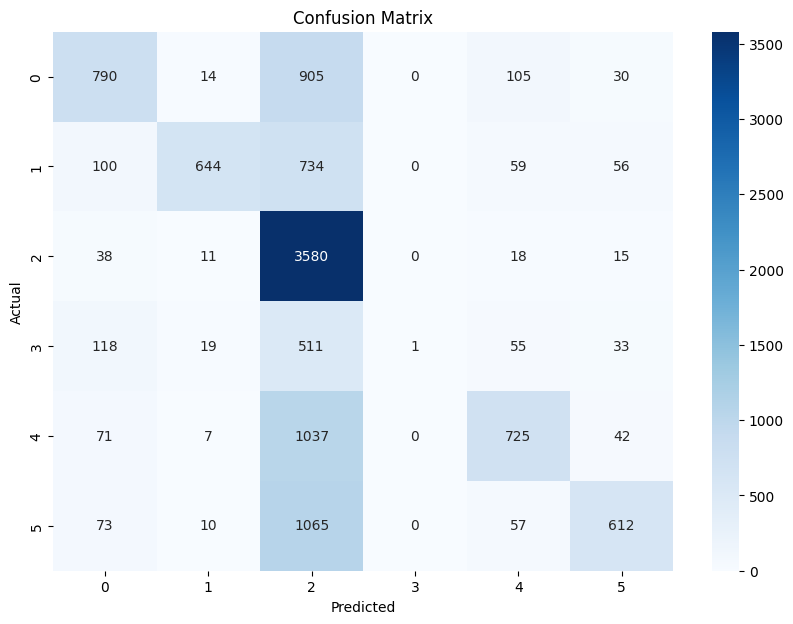

Accuracy: 0.5507
F1-score: 0.5142

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.43      0.52      1844
           1       0.91      0.40      0.56      1593
           2       0.46      0.98      0.62      3662
           3       1.00      0.00      0.00       737
           4       0.71      0.39      0.50      1882
           5       0.78      0.34      0.47      1817

    accuracy                           0.55     11535
   macro avg       0.75      0.42      0.45     11535
weighted avg       0.68      0.55      0.51     11535



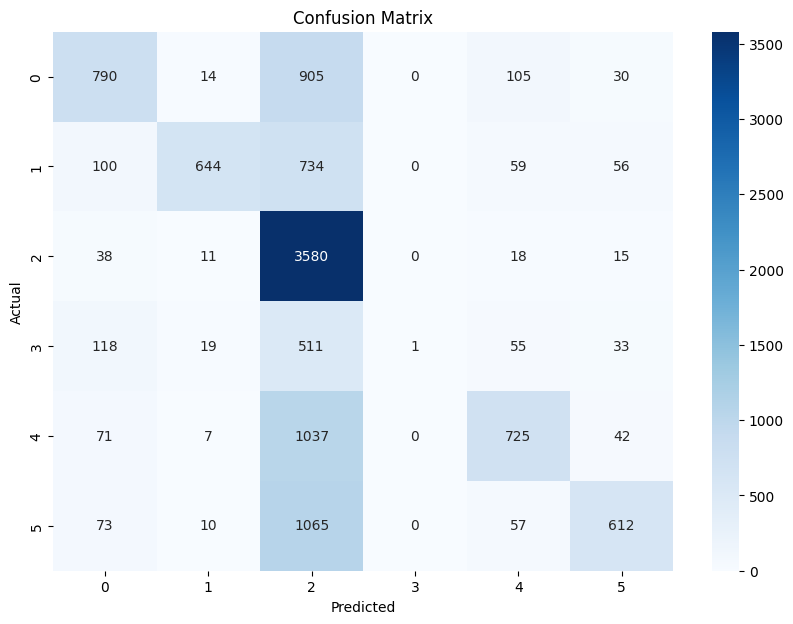

In [73]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true = y_test
        y_pred = predicted.cpu().numpy()

        # Accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f'Accuracy: {accuracy:.4f}')

        # F1-score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f'F1-score: {f1:.4f}')

        # Подробный отчёт
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))

        # Матрица ошибок
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

model.to(device)
evaluate_model(model, X_test, y_test)

# Оценка модели
evaluate_model(model, X_test, y_test)


График потерь

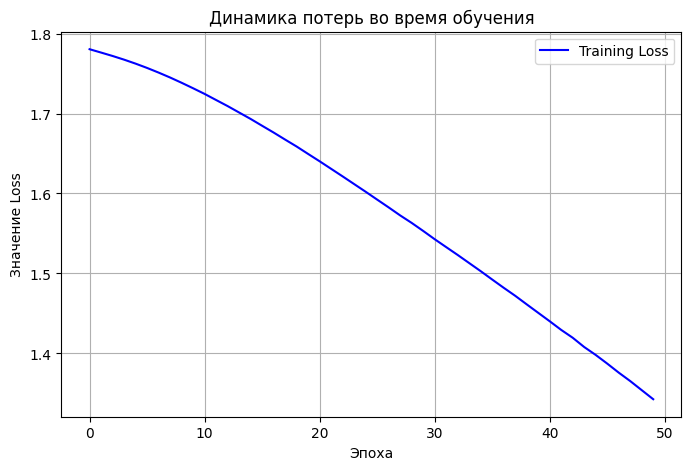

In [75]:
plt.figure(figsize=(8, 5))
plt.plot(loss_values, label='Training Loss', color='blue')
plt.title('Динамика потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Значение Loss')
plt.legend()
plt.grid(True)
plt.show()
